# Data preparation

In [21]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import glob, os

data = pd.read_csv('H:/fast trip/Copy of KC_Metro_4_15_2014_OBS_Data.csv', index_col=0)
#clean data
data = data.loc[data['DWELL_SEC'] <= 90]
data = data[pd.notnull(data['ONS'])]
data = data[data.BUS_TYPE != '??']
#Converting categorical variables to factor 0 or 1 mark data
#Articulated bus or not
data['Artic'] = data['BUS_TYPE'].map({'Artic': 1, 'Standard': 0})
#Rapid ride or not
data['rapid_ride'] = data['RTE'].map({671: 1, 672: 1, 673: 1, 674: 1, 675: 1})
data.rapid_ride = data.rapid_ride.fillna(0)
#Downtown stop or not
dict_stop_id = dict((el,1) for el in [455, 456, 501, 502, 532, 533, 565, 566, 621, 622, 623, 624, 1082, 1083, 1084, 1086, 1108, 1109, 1121, 1122, 1192, 1193])
data['downtown_stop'] = data['STOP_ID'].map(dict_stop_id)
data.downtown_stop = data.downtown_stop.fillna(0)
#interactors
data['OnsArt'] = data.apply(lambda row: (row['ONS']*row['Artic']), axis=1)
data['OffsArt'] = data.apply(lambda row: (row['OFFS']*row['Artic']), axis=1)
data['OnsRapid'] = data.apply(lambda row: (row['ONS']*row['rapid_ride']), axis=1)
data['OffsRapid'] = data.apply(lambda row: (row['OFFS']*row['rapid_ride']), axis=1)
data['OnsDowntown'] = data.apply(lambda row: (row['ONS']*row['downtown_stop']), axis=1)
data['OffsDowntown'] = data.apply(lambda row: (row['OFFS']*row['downtown_stop']), axis=1)
data['ArticRapid'] = data.apply(lambda row: (row['Artic']*row['rapid_ride']), axis=1)
data['ArticDowntown'] = data.apply(lambda row: (row['Artic']*row['downtown_stop']), axis=1)
#Ons + Offs
data['ON+OFF'] = data.apply(lambda row: (row['ONS']+row['OFFS']), axis=1)
print 'end'

end


# Cross Testing

In [22]:
#Appling 90% of data as train dataset, 10% as test dataset
msk = np.random.rand(len(data)) < 0.9
df_train = data[msk]
df_test = data[~msk]
print 'The train dataset has', len(df_train), 'trips, and the test dataset has', len(df_test), 'trips; the total dataset includes', len(data), 'trips'

####another method#########################
#from sklearn.cross_validation import train_test_split
#data_train, data_test = train_test_split(data, test_size = 0.9, random_state=42)

The train dataset has 89367 trips, and the test dataset has 10033 trips; the total dataset includes 99400 trips


In [23]:
lm = smf.ols(formula = 'DWELL_SEC ~ ONS + OFFS + Artic + rapid_ride + downtown_stop + OnsArt + OffsArt + rapid_ride + ArticRapid + ArticDowntown + OnsRapid + OffsRapid + OnsDowntown + OffsDowntown', data = df_train).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              DWELL_SEC   R-squared:                       0.420
Model:                            OLS   Adj. R-squared:                  0.420
Method:                 Least Squares   F-statistic:                     5888.
Date:                Fri, 11 Dec 2015   Prob (F-statistic):               0.00
Time:                        17:33:06   Log-Likelihood:            -3.5211e+05
No. Observations:               89367   AIC:                         7.042e+05
Df Residuals:                   89355   BIC:                         7.044e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Intercept         4.1523      0.068     60.875      0.000         4.019     4.286
ONS               3.6333      0.034    106.509      0.000         3.566     3.700
OFFS              2.5581      0.034     75.942      0.000         2.492     2.624
Artic             2.7428      0.104     26.268      0.000         2.538     2.948
rapid_ride        2.1769      0.075     29.053      0.000         2.030     2.324
downtown_stop     8.8552      0.270     32.848      0.000         8.327     9.384
OnsArt           -0.3336      0.043     -7.831      0.000        -0.417    -0.250
OffsArt          -0.6767      0.040    -16.910      0.000        -0.755    -0.598
ArticRapid        2.1769      0.075     29.053      0.000         2.030     2.324
ArticDowntown     8.8552      0.270     32.848      0.000         8.327     9.384
OnsRapid         -1.3944      0.039    -35.701      0.000        -1.471    -1.318
OffsRapid        -0.7777      0.036    -21.539      0.000        -0.848    -0.707
OnsDowntown      -1.6916      0.060    -28.299      0.000        -1.809    -1.574
OffsDowntown     -1.2114      0.064    -19.059      0.000        -1.336    -1.087
==============================================================================
Omnibus:                    29208.011   Durbin-Watson:                   1.910
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           529757.216
Skew:                           1.108   Prob(JB):                         0.00
Kurtosis:                      14.720   Cond. No.                     4.59e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 9.06e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

# Appling the dewell time model with the rest 10% data

In [24]:
#Estimate dwell time for the 'test' dataset
df_est = pd.DataFrame(lm.predict(df_test), index = df_test.index, columns = ['Dwell_Time_Esti'])
df_test = pd.concat([df_test, df_est], axis=1, join='inner')
df_test.head()

,PATTERN_ID,BLK,RTE,DIR,SCH_ST_MIN,OPD_DATE,VEHICLE_ID,BUS_TYPE,ENGINE,NUM_DOORS,...,OnsArt,OffsArt,OnsRapid,OffsRapid,OnsDowntown,OffsDowntown,ArticRapid,ArticDowntown,ON+OFF,Dwell_Time_Esti
TRIP_ID,,,,,,,,,,,,,,,,,,,,,
25566688,21002556,202,2,S,307,15-Apr-14,4191,Standard,Trolley,2,...,0,0,0,0,0,0,0,0,2,11.418905
24664009,20073005,7105,73,S,310,15-Apr-14,2605,Artic,Motor,2,...,0,0,0,0,0,0,0,0,0,6.895157
18114004,10187008,18201,187,N,313,15-Apr-14,7041,Standard,Motor,2,...,0,0,0,0,0,0,0,0,0,4.152312
24663174,20674021,67305,674,S,312,15-Apr-14,6047,Artic,Motor,3,...,0,1,0,1,0,0,1,0,1,12.352703
24974767,20675007,67501,675,S,273,15-Apr-14,6088,Artic,Motor,3,...,0,0,0,0,0,0,1,0,0,11.248953


# Plotting Scatter

In [25]:
import pylab
%matplotlib inline

10033
3705
4546


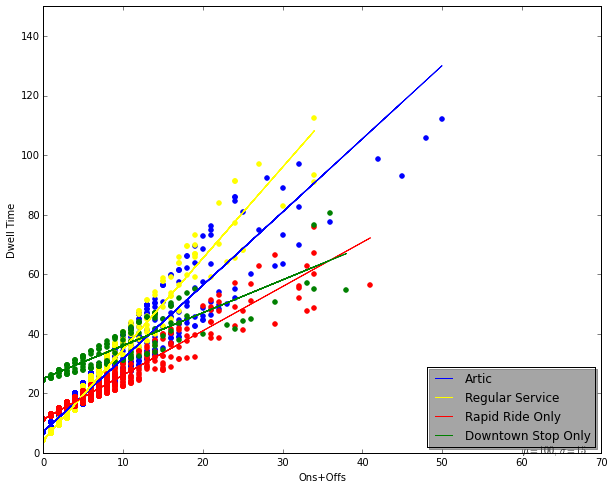

In [31]:
df_test_Artic = df_test[(df_test.Artic==1) & (df_test['rapid_ride']==0) & (df_test['downtown_stop']==0)]
df_test_StandardService = df_test[df_test.Artic==0]
df_test_RapidRide = df_test[df_test.ArticRapid==1]
df_test_DowntownStop = df_test[df_test.ArticDowntown==1]
print len(df_test)
print len(df_test_Artic)
print len(df_test_StandardService)

# plot the data itself
x1 = df_test_Artic['ON+OFF']
y1 = df_test_Artic['Dwell_Time_Esti']
#z1 = df_test_Artic['DWELL_SEC']
fig, ax = plt.subplots()
# plot the data itself
ax.scatter(x1, y1, color = 'blue')
#ax.scatter(x1, z1, color = 'green')
#plot the trend line
fit = np.polyfit(x1, y1, deg=1)
ax.plot(x1, fit[0] * x1 + fit[1], color='blue', label='Artic')

x2 = df_test_StandardService['ON+OFF']
y2 = df_test_StandardService['Dwell_Time_Esti']
z2 = df_test_StandardService['DWELL_SEC']
# plot the data itself
ax.scatter(x2, y2, color = 'yellow')
#plot the trend line
fit = np.polyfit(x2, y2, deg=1)
ax.plot(x2, fit[0] * x2 + fit[1], color='yellow', label= 'Regular Service')

x3 = df_test_RapidRide['ON+OFF']
y3 = df_test_RapidRide['Dwell_Time_Esti']
z3 = df_test_RapidRide['DWELL_SEC']
# plot the data itself
ax.scatter(x3, y3, color = 'red')
#plot the trend line
fit = np.polyfit(x3, y3, deg=1)
ax.plot(x3, fit[0] * x3 + fit[1], color='red', label= 'Rapid Ride Only')

x4 = df_test_DowntownStop['ON+OFF']
y4 = df_test_DowntownStop['Dwell_Time_Esti']
z4 = df_test_DowntownStop['DWELL_SEC']
# plot the data itself
ax.scatter(x4, y4, color = 'green')
#plot the trend line
fit = np.polyfit(x4, y4, deg=1)
ax.plot(x4, fit[0] * x4 + fit[1], color='green', label='Downtown Stop Only')

plt.xlabel('Ons+Offs')
plt.ylabel('Dwell Time')
plt.text(60, .025, r'$\mu=100,\ \sigma=15$')
ax.legend(loc='lower right', shadow=True)
pylab.rcParams['figure.figsize'] = (10.0, 8.0)
plt.axis([0, 70, 0, 150])

fig.show()